In [2]:
import numpy as np
import numpy.ma as ma

from astropy.table import QTable, Table

import sys
#sys.path.insert(1,"/Users/kellydouglass/Documents/Research/Rotation_curves/RotationCurves/spirals/")
sys.path.insert(1, '/Users/nityaravi/Documents/GitHub/RotationCurves/spirals')
#sys.path.insert(1, '/home/kelly/Documents/RotationCurves/spirals/')
from DRP_rotation_curve import extract_data
from DRP_rotation_curve_plottingFunctions import plot_vel
from DRP_vel_map_functions import model_vel_map, \
                                  find_center, \
                                  find_phi, \
                                  deproject_spaxel, \
                                  find_vel_bounds, \
                                  find_sigma_bounds
from DRP_vel_map_plottingFunctions import plot_rot_curve

#from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib notebook

In [3]:
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/home/kelly/Documents/Data/SDSS/dr16/manga/spectro/'
#MANGA_FOLDER = '/Users/kellydouglass/Documents/Research/data/SDSS/dr17/manga/spectro/'
MANGA_FOLDER = '/Users/nityaravi/Documents/Research/data/manga/'

#VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v2_4_3/2.2.1/HYB10-GAU-MILESHC/'
#VEL_MAP_FOLDER = MANGA_FOLDER + 'analysis/v'
VEL_MAP_FOLDER = MANGA_FOLDER + 'DR17/'
DRP_FILENAME = MANGA_FOLDER + 'DR17/' + 'drpall-v3_1_1.fits'

NSA_FILENAME = '/Users/nityaravi/Documents/Research/data/nsa_v1_0_1.fits'

# Sample galaxy properties

In [4]:
DRP_table = Table.read( DRP_FILENAME, format='fits')
DRP_index = {}

for i in range(len(DRP_table)):
    gal_ID1 = DRP_table['plateifu'][i]

    DRP_index[gal_ID1] = i

In [711]:
# worked but bad fits

#gal_ID = '11958-3701' 
#gal_ID = '11871-9101'
#gal_ID = '10497-3704' # try center (19,21)
#gal_ID = '9874-6101'
#gal_ID = '9487-9102' # try center (32,34)
#gal_ID = '9042-6101'
#gal_ID = '8244-3701' # try center (22,22)
#gal_ID = '8084-12703'
#gal_ID = '7990-1902'
#gal_ID = '8713-9102'
#gal_ID = '8553-1901' # try phi -= 0.5*pi
#gal_ID = '8550-12703'
#gal_ID = '8446-1901' # try ctr (17,17)
#gal_ID = '8442-12701' # might actually be okay
#gal_ID = '8313-6102'
#gal_ID = '8253-12704' # try ctr (35,38)
#gal_ID = '8096-12701'
#gal_ID = '8096-6102'
#gal_ID = '8095-3701'


# didn't work
#gal_ID = '7958-6101' # nan Hess, domain error --> try ctr(28,28) FAILED
#gal_ID = '8077-12702' # singlar hessian --> ??
#gal_ID = '8249-3704' # nan Hess --> try ctr (23,20) FAILED
#gal_ID = '8250-6101' #mass out not def --> try ctr (26,25) FAILED
#gal_ID = '8252-3701' #list index out of range --> try ctr (20,22) FAILED
#gal_ID = '8252-9101' #mass out not def --> try ctr (30,30)
#gal_ID = '8313-12702' # list index out of range --> try ctr(36,38)
#gal_ID = '8717-3704' # list ind out of range --> try ctr(20,22)
#gal_ID = '8727-12705' #singular hess --> try ctr(35,32), phi += 0.5*pi
#gal_ID = '9000-1901' #singular hess --> try phi += 0.5*pi
#gal_ID = '9487-3703' # math domain error --> try ctr(20,22)
#gal_ID = '9491-6101' #list index out of range --> try ctr (25,25)
#gal_ID = '10519-6103' # singular hess --> ??
#gal_ID = '12085-6101' # math domain err --> try ct (28,28)


manga_plate, manga_IFU = gal_ID.split('-')

In [712]:
maps = extract_data(VEL_MAP_FOLDER, gal_ID, ['Ha_vel', 'Ha_flux', 'Ha_sigma', 'r_band'])

mr_band = ma.array(maps['r_band'], mask=maps['Ha_vel_mask'])
mHa_vel = ma.array(maps['Ha_vel'], mask=maps['Ha_vel_mask'])
mHa_vel_ivar = ma.array(maps['Ha_vel_ivar'], mask=maps['Ha_vel_mask'])

mHa_sigma = ma.array(maps['Ha_sigma'], 
                     mask=maps['Ha_sigma_mask'] + maps['Ha_vel_mask'])#np.logical_or(Ha_sigma_mask > 0, Ha_vel_mask > 0))
mHa_sigma_ivar = ma.array(maps['Ha_sigma_ivar'], 
                          mask=maps['Ha_sigma_mask'] + maps['Ha_vel_mask'])

SN = maps['Ha_flux']*np.sqrt(maps['Ha_flux_ivar'])
m5Ha_vel = ma.array(maps['Ha_vel'], 
                    mask=np.logical_or(maps['Ha_vel_mask'] > 0, np.abs(SN) < 5))#0.05*np.max(np.abs(SN))))
print('5% of the maximum S/N:', 0.05*np.max(np.abs(SN)))

5% of the maximum S/N: 4.540958404541016


In [713]:
i_DRP = DRP_index[gal_ID]
phi_EofN_deg = DRP_table['nsa_elpetro_phi'][i_DRP]

# Test `find_center`

In [714]:
maybe_center = find_center(mHa_vel)

In [715]:
maybe_center

(26, 38)

In [706]:
maybe_center = (35,38)

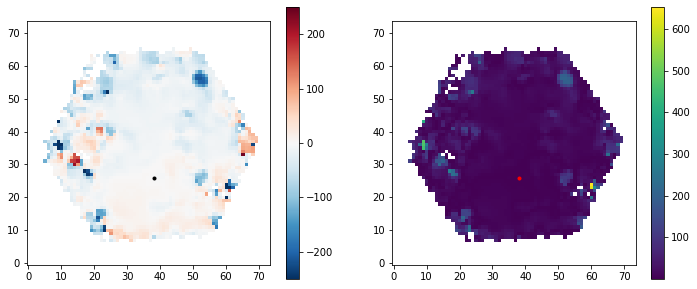

In [716]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.imshow(mHa_vel, origin='lower', cmap='RdBu_r', vmin=-250, vmax=250)
plt.plot(maybe_center[1], maybe_center[0], 'k.')
plt.colorbar()

plt.subplot(122)
plt.imshow(np.abs(mHa_vel), origin='lower')
plt.plot(maybe_center[1], maybe_center[0], 'r.')
plt.colorbar();

# Test `find_phi`

In [717]:
#maybe_center=(30,30)
phi_EofN_deg = DRP_table['nsa_elpetro_phi'][i_DRP]
maybe_phi = find_phi(maybe_center,phi_EofN_deg ,mHa_vel)

3.228352621640581


In [718]:
phi_EofN_deg

4.97098

In [719]:
maybe_phi*180/np.pi

184.97098

In [520]:
f = '/Users/nityaravi/Documents/Research/data/manga/DRP_map_Hessians/' + gal_ID + '_Hessian.npy'

hess = np.load(f)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nityaravi/Documents/Research/data/manga/DRP_map_Hessians/8250-6101_Hessian.npy'

In [508]:
hess.shape

(8, 8)

In [509]:
hess

array([[nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan]])

### gal2 = '8095-1902'
f2 = f = '/Users/nityaravi/Documents/Research/data/manga/DRP_map_Hessians/' + gal2 + '_Hessian.npy'
hess2 = np.load(f2)

In [25]:
hess2

array([[ 3.51538961e+01,  6.09741926e+02,  2.92474276e+02,
        -2.31750093e+02,  6.41026738e+01,  2.08474872e+00,
        -1.09583186e+02,  8.61984956e+01],
       [ 6.09741926e+02,  2.26589671e+05,  3.57541987e+03,
        -2.12927448e+03, -1.40401431e+04,  7.70006677e+02,
        -4.08133932e+04,  3.17420953e+04],
       [ 2.92474276e+02,  3.57541987e+03,  3.39160808e+03,
        -2.16707455e+03,  1.24881322e+03,  1.24362210e+01,
        -7.00061225e+02,  5.43832457e+02],
       [-2.31750093e+02, -2.12927448e+03, -2.16707455e+03,
         2.14817464e+03,  2.13473938e+02, -7.35432852e+00,
         4.18833742e+02, -3.21428504e+02],
       [ 6.41026738e+01, -1.40401431e+04,  1.24881322e+03,
         2.13473938e+02,  8.48141532e+04, -4.82617692e+01,
         2.26485138e+03, -1.90408018e+03],
       [ 2.08474872e+00,  7.70006677e+02,  1.24362210e+01,
        -7.35432852e+00, -4.82617692e+01,  2.63158979e+00,
        -1.38725996e+02,  1.08250130e+02],
       [-1.09583186e+02, -4.081339